In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sys
import platform
if platform.system() == 'Linux':
    sys.path.insert(0,'/nethome/palmerio/Dropbox/Plotting_GUI/Src')
elif platform.system() == 'Darwin': 
    sys.path.insert(0,'/Users/palmerio/Dropbox/Plotting_GUI/Src')

import plotting_functions as pf
root_dir = Path('/Users/palmerio/Science_projects/')


In [78]:
def Stern_bins(fname=None):
    if fname is None:
        fname = str(root_dir/'GRB_population_model/observational_constraints/lognlogp.stern.dat')
    bins = pf.read_column(fname, 0, array=False)
    bins.append(1.8)
    bins = 10**np.asarray(bins)/0.75
    bins2 = []
    for i in range(len(bins)-8):
        bins2.append(bins[i])
    bins2.append(16.)
    bins2.append(20.)
    bins2.append(28.)
    bins2.append(50.)
    bins2 = np.asarray(bins2, dtype=float)
    return bins2

def efficiency_correction_Stern(pflx, c_e0=0.097, nu=2.34, norm=0.7):
    """
        The efficiency function of BATSE for detecting GRBs as a function of peak flux, derived by Stern+01
        c_e0 is in [counts/s/cm2]
        pflx is in [ph/s/cm2]
    """
    c_e = pflx * 0.75  # the conversion factor from counts to pflx comes from the Stern+01 paper as well, figure 7.
    return norm * (1.0 - np.exp(-(c_e/c_e0)**2) )**nu

def xerr_from_bins(bins, log=False):
    """
        Convenience function to easily calculate the x_err from bins to
        represent a histogram as crosses on a plot
        returns:
        - x the middle point of the bin in the x direction
        - x_errp the extent of the bin from x up to the right bin edge
        - x_errm the extent of the bin from x down to the left bin edge
    """
    if log:
        x = np.sqrt(bins[1:] * bins[:-1])
    else:
        x = 0.5 * (bins[1:] + bins[:-1])

    x_errp = bins[1:] - x
    x_errm = x - bins[:-1]

    return x, x_errp, x_errm

def filter_df(df, filtering_key, lim_min=None, lim_max=None, equal=None, errors='raise', strip=None, string=False):
    """
        Filter a df using a criteria based on filtering_key
    """
    if not string:
        df[filtering_key] = pd.to_numeric(df[filtering_key], errors=errors)
    else:
        df[filtering_key] = df[filtering_key].str.strip(strip)

    if (lim_min is None) and (lim_max is None) and (equal is None):
        raise ValueError
    elif (lim_min is not None) and (lim_max is not None) and (equal is None):
        cond_min = df[filtering_key] >= lim_min
        cond_max = df[filtering_key] <= lim_max
        cond = cond_min & cond_max
    elif lim_min is not None:
        cond = df[filtering_key] >= lim_min
    elif lim_max is not None:
        cond = df[filtering_key] <= lim_max
    elif equal is not None:
        cond = df[filtering_key] == equal
    else:
        print("lim_min = {}".format(lim_min))
        print("lim_max = {}".format(lim_max))
        print("equal = {}".format(equal))
        raise ValueError("You cannot provide all these arguments. Filtering must be "
                         "lim_min and/or lim_max OR equal")
    df_out = df[cond].copy()
        
    return df_out


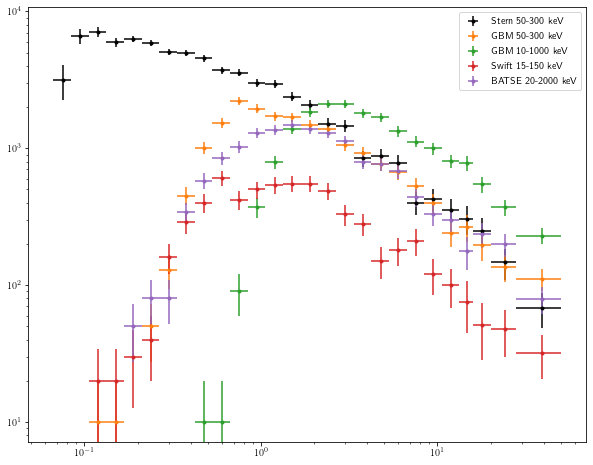

In [82]:

def plot_logNlogP(fname, key, func=None, func_args={}, bins=None, sep=None, hdr=None, density=False,
                  cols=None, ax=None, eff=False, errors='raise', **kwargs):
    # Read data
    df_obs = pd.read_csv(fname, sep=sep, header=hdr, names=cols, low_memory=False)
    # Strip the colum names to remove whitespaces
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    
    # Apply function to the data
    if func is None:
        df_prop = pd.to_numeric(df_obs[key], errors=errors)
    # If func is a list, iterate through the list and apply each function
    elif isinstance(func, list):
        if not isinstance(func_args, list):
            raise ValueError
        df_prop = df_obs.copy()
        for i, func_i in enumerate(func):
            df_prop = func_i(df_prop, **func_args[i])
        df_prop = pd.to_numeric(df_prop[key], errors=errors)
    else:
        df_prop = func(df_obs.copy(), **func_args)
        df_prop = pd.to_numeric(df_prop[key], errors=errors)

    if bins is None:
        bins = Stern_bins()
    x, x_errp, x_errm = xerr_from_bins(bins)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
    hist, bins = np.histogram(df_prop, bins=bins)
    hist_err = np.sqrt(hist)
    
    if eff:
        hist =  hist / efficiency_correction_Stern(x)
        hist_err =  hist_err / efficiency_correction_Stern(x)
    if density:
        N_tot = np.sum(hist)
    else:
        N_tot = 1
    delta_bins = np.log10(bins[1:]/bins[:-1])
    hist = hist/(N_tot*delta_bins)
    hist_err = hist_err/(N_tot*delta_bins)

    ax.errorbar(x, hist, xerr=[x_errm, x_errp], yerr=hist_err,
                fmt='.', **kwargs)

    return

fig, ax = plt.subplots(figsize=(10,8))
plot_logNlogP(fname = Path('BATSE_cat/Stern_cat.txt'), key='Flux',
              cols = ['TJD/Char', 'Start', 'Trigger', 'Flux', 'RAdeg',
                      'DEdeg', 'Error', 'T90', 'N50', 'K98', 'Gap'],
              hdr = 48, label='Stern 50-300 keV',
              sep = '\t',
              color = 'k', ax=ax, eff=True)
plot_logNlogP(fname = Path('GBM_cat/fermi_GBM_cat_total.dat'), key='pflx_band_phtfluxb',
              func=filter_df,
              func_args={'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
              hdr = 2, label='GBM 50-300 keV',
              sep = '|',
              color = 'C1', ax=ax, errors='coerce')
plot_logNlogP(fname = Path('GBM_cat/fermi_GBM_cat_total.dat'), key='pflx_band_phtflux',
              func=filter_df,
              func_args={'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
              hdr = 2, label='GBM 10-1000 keV',
              sep = '|',
              color = 'C2', ax=ax, errors='coerce')
plot_logNlogP(fname = Path('Swift_cat/Swift_cat_complete.txt'), key='bat_peakfluxp',
              func=filter_df,
              func_args={'filtering_key':'bat_t90', 'lim_min':2, 'errors':'coerce'},
              hdr = 2, label='Swift 15-150 keV',
              sep = '|',
              color = 'C3', ax=ax, errors='coerce')
plot_logNlogP(fname = Path('BATSE_cat/BATSE_cat_complete_5B.txt'), key='pflx_band_phtflux',
              func=filter_df,
              func_args={'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
              hdr = 2, label='BATSE 20-2000 keV',
              sep = '|',
              color = 'C4', ax=ax, errors='coerce')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
